# Registrar dos o mas imágenes a partir de coordenadas en común

Utilizando las coordenadas celestes del centro del campo, descargamos una lista de objetos disponibles en GAIA. Luego, transformamos las coordenadas celestes de los objetos de la lista a coordenadas de la imagen utilizando la información del WCS.

En una primera instancia, esto se hace con una imagen de referencia para generar una lista de coordenadas, en el sistema de la imagen, que sirvan como referencia. Para luego convertir el resto de las imagenes al sistema de refencia.
Se necesita que todas las imagenes involucradas tengan la información del WCS en sus headers.

In [102]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path

from astropy.coordinates import SkyCoord

from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import astroalign as aa

h = '/home/jpcalderon/'
mosaic = h + '2022/Antlia/data/2020+2021/Valdes/mosaic/'

## Coordenadas del centro de la imagen de referencia

In [50]:
# Coordenadas aproximadas del centro del campo
coord = SkyCoord.from_name('NGC 3268')
ra = str(coord.ra.deg)
dec = str(coord.dec.deg)

print (ra, dec)

157.50270440885 -35.32542210869


## Descargamos un catalogo de GAIA centrado en las coordenadas celestes anteriores

In [51]:
if os.path.isfile('gaia_N3268.fits'):
    gpandas = Table.read ( 'gaia_N3268.fits', format = 'fits' ).to_pandas()
else:
    # Query tomado de: https://arxiv.org/pdf/1804.09378.pdf
    from astroquery.gaia import Gaia

    query = "SELECT * \
             from gaiaedr3.gaia_source \
             where 1 = CONTAINS( POINT ( 'ICRS', ra, dec ), CIRCLE ( 'ICRS', " + ra + ", " + dec + ", 2.0 ) ) \
              AND parallax_over_error > 10 \
              AND phot_g_mean_flux_over_error>50 \
              AND phot_rp_mean_flux_over_error>20 \
              AND phot_bp_mean_flux_over_error>20 \
              AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
              AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
              AND visibility_periods_used>8 \
              AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

    job = Gaia.launch_job_async ( query, dump_to_file = True, output_format = 'fits', 
                             output_file = 'gaia_N3268.fits' )
    gtable = job.get_results()
    gpandas = gtable.to_pandas() # Convierte la tabla de gaia a pandas
    
print ( "[*] Cant. de resultados:", len(gpandas) )

[*] Cant. de resultados: 28366


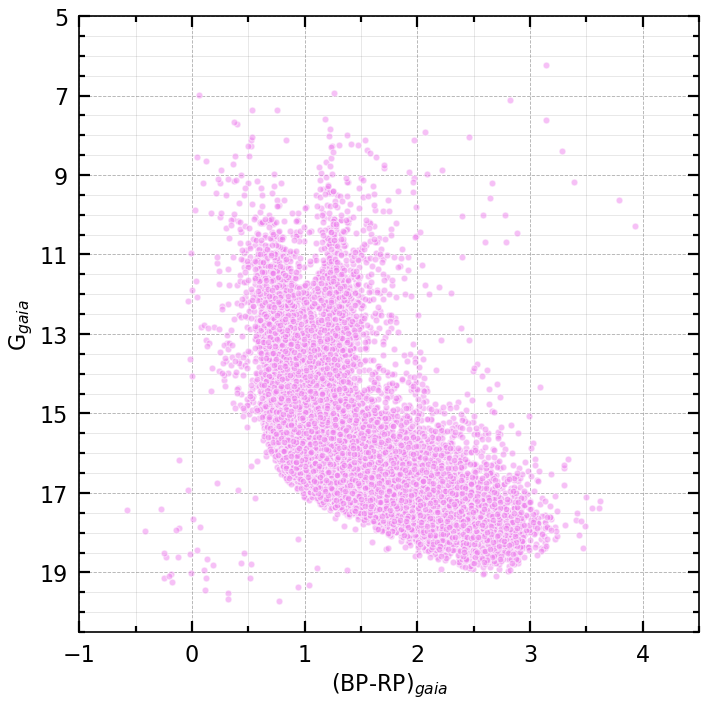

In [52]:
%matplotlib inline

fig, ax0 = plt.subplots ( 1, 1, figsize = (10, 10), dpi = 80 )
    
ax0.scatter ( 'bp_rp' , 'phot_g_mean_mag', data = gpandas,
             alpha = 0.5, color = 'violet', edgecolor = "white", s = 6**2, zorder = 9 )

ax0.set_xlabel ( '(BP-RP)$_{gaia}$' )
ax0.set_ylabel ( 'G$_{gaia}$' )

xmin, xmax = ax0.set_xlim()
ymin, ymax = ax0.set_ylim()

mkgrid ( [ax0], xmin, xmax, 1.0, 0.5, ymin, ymax, 2.0, 0.5 )
plt.gca().invert_yaxis()

plt.show()

## Coordenadas celestes de referencia

In [53]:
positions = SkyCoord( gpandas['ra'].tolist() * u.deg, gpandas['dec'].tolist() * u.deg, frame = 'fk5' )
# Con esto puedo crear un archivo x,y con las coordenadas
# pd.DataFrame({'ra':positions.ra.deg, 'dec':positions.dec.deg}).to_csv ( "output/positions.csv", 
#                                                                       index = False, header = None )
print(len(positions))
positions

28366


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(157.37300584, -34.33602071), (157.36975126, -34.33321571),
     (157.36639401, -34.3242968 ), ..., (157.46718349, -35.73326795),
     (157.51632173, -35.70830013), (157.48191159, -35.70474985)]>

# Tomando la imagen en el filtro g como referencia, construyo la lista de coordenadas 'source'

In [109]:
filter = 'g'
img = mosaic + 'antlia0' + filter + '.fits'
with fits.open ( img ) as hdul:
    data_ref = hdul[0].data
    wcs_ref  = WCS ( hdul[0].header )
x_ref, y_ref = wcs_ref.world_to_pixel ( positions )
source = np.array ( list(zip(x_ref,y_ref)) )

## Dentro de un loop con los restantes filtros, obtengo la transformacion de coordenadas y genero una nueva imagen registrada a la imgen de referencia, para cada filtro

In [110]:
for filter in [ 'r', 'i', 'z' ]:
    print ( '[*] Procesing: ', filter )
    
    img = mosaic + 'antlia0' + filter + '.fits'
    with fits.open ( img ) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        wcs  = WCS ( header )
    x, y = wcs.world_to_pixel ( positions )
    target = np.array ( list(zip(x,y)) )

    tform = aa.estimate_transform ( 'affine', target, source )
    print ( "\nRotation: %.2f degrees" %(tform.rotation * 180.0 / np.pi) )
    print ( "Scale factor: %.2f, %.2f" %(tform.scale) )
    print ( "Translation: (x, y) = (%.2f, %.2f)" % (tform.translation[0], tform.translation[1]) )
    print ( "Tranformation matrix:\n %s" % (tform.params) )

    aligned_image, footprint = aa.apply_transform (tform, data, data_ref, propagate_mask = False )
    fits.writeto ( os.path.splitext(img)[0] + '_registered.fits', aligned_image, header, overwrite = True )
    print ( '\n[*] done!\n')

[*] Procesing:  r

Rotation: 0.00 degrees
Scale factor: 1.00, 1.00
Translation: (x, y) = (20.00, -2.00)
Tranformation matrix:
 [[ 1.00000000e+00  3.60222207e-16  2.00000000e+01]
 [ 3.52847464e-17  1.00000000e+00 -2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[*] done!

[*] Procesing:  i

Rotation: -0.00 degrees
Scale factor: 1.00, 1.00
Translation: (x, y) = (-18.00, 2.00)
Tranformation matrix:
 [[ 1.00000000e+00  3.60222207e-16 -1.80000000e+01]
 [-1.24246145e-18  1.00000000e+00  2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[*] done!

[*] Procesing:  z

Rotation: -0.00 degrees
Scale factor: 1.00, 1.00
Translation: (x, y) = (49.00, 21.00)
Tranformation matrix:
 [[ 1.00000000e+00  3.60222207e-16  4.90000000e+01]
 [-2.06356274e-17  1.00000000e+00  2.10000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[*] done!



---

In [5]:
def mkgrid(ax, xmin, xmax, xdelta, xxdelta, ymin, ymax, ydelta, yydelta):
    for a in ax:  
        #a.axhline ( 0, color = 'black', linestyle = '-', linewidth = 2, alpha = 0.9, zorder = -1 )

        a.set_xticks ( np.arange(np.floor(xmin), np.ceil(xmax), xdelta) )
        a.set_xticks ( np.arange(np.floor(xmin), np.ceil(xmax), xxdelta), minor = True )
        a.set_yticks ( np.arange(np.floor(ymin), np.ceil(ymax), ydelta) )
        a.set_yticks ( np.arange(np.floor(ymin), np.ceil(ymax), yydelta), minor = True )
        a.grid ( which = 'minor', color = 'gray', alpha = 0.2, linestyle = '-' )
        a.grid ( which = 'major', color = 'gray', alpha = 0.6, linestyle = '--' )

        plt.setp ( a.spines.values(), linewidth = 1.5 )
        a.tick_params ( which = 'major', direction = 'inout' )
        a.tick_params ( which = 'minor', direction = 'in' )
        a.yaxis.set_ticks_position ( 'both' )
        a.xaxis.set_ticks_position ( 'both' )
        a.tick_params ( direction = 'in', pad = 10 )  
        a.tick_params ( which = 'both', width = 2 )
        a.tick_params ( which = 'major', length = 10 )
        a.tick_params ( which = 'minor', length = 5 )
        #a.legend ( fontsize = 16 )

        for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                 a.get_xticklabels() + a.get_yticklabels()):
            item.set_fontsize(20)
            
        #a.set_xlim ( [ xmin, xmax ] )
        #if a == ax1:
        #    a.set_ylim ( [ -0.5, 0.5 ] )
        #elif a==ax2:
        #    a.set_ylim ( [ -0.1, 0.8 ] )